COGS 118B Final Project - Credit Risk Prediction with Hybrid Modeling

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import plot_tree

import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 

In [2]:
# import dataset
app_df = pd.read_csv('datasets/application_record.csv')
credit_df = pd.read_csv('datasets/credit_record.csv')

# Drop FLAG_MOBIL column because it is a constant
print(app_df['FLAG_MOBIL'].value_counts())
app_df = app_df.drop("FLAG_MOBIL", axis=1)
app_df

FLAG_MOBIL
1    438557
Name: count, dtype: int64


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,0,0,0,NaN,2.0


In [3]:
# Data cleaning for classification
credit_df['STATUS'] = credit_df['STATUS'].replace('X', '-2')
credit_df['STATUS'] = credit_df['STATUS'].replace('C', '-1')
credit_df['STATUS'] = credit_df['STATUS'].astype(int)
credit_df['MONTHS_BALANCE'] = credit_df['MONTHS_BALANCE'].astype(int)

In [4]:
# generate a credit level label for each client based on credit history record
def two_classes(client):
    if client['STATUS'].max() <= 0:
        recent = client[client['MONTHS_BALANCE'] >= -6]
        if recent['STATUS'].max() > 0:
            return 'Subprime'
        return 'Prime'
    return 'Subprime'

label_df_2 = credit_df.groupby('ID').apply(two_classes).to_frame()
label_df_2 = label_df_2.rename(columns={0: 'CLASS'})


def four_classes(client):
    recent = client[client['MONTHS_BALANCE'] >= -6]
    worst_status = client['STATUS'].max()
    worst_recent_status = recent['STATUS'].max()
    if recent.shape[0] == 0:
        worst_recent_status = -3

    if worst_status < 0:
        if worst_recent_status < 0:
            return 'Super-prime'
    if worst_status <= 0:
        if worst_recent_status <= 0:
            return 'Prime'
    if worst_status <= 3:
        if worst_recent_status <= 1:
            return 'Near-prime'
    '''
    if worst_status <= 5:
        if worst_recent_status <= 3:
            return 'Subprime'
    '''
    return 'Subprime'
    
label_df_4 = credit_df.groupby('ID').apply(four_classes).to_frame()
label_df_4 = label_df_4.rename(columns={0: 'CLASS'})

/var/folders/sb/cdw7gr054nvc469rwn15_4q00000gn/T/ipykernel_76237/1374351081.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_df_2 = credit_df.groupby('ID').apply(two_classes).to_frame()
/var/folders/sb/cdw7gr054nvc469rwn15_4q00000gn/T/ipykernel_76237/1374351081.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_df_4 = credit_df.groupby('ID').apply(four_classes).to_frame()


In [5]:
# concat label to the application dataframe and change index to ID
label_app_df_2 = pd.merge(app_df, label_df_2, left_on='ID', right_index=True, how='inner')
label_app_df_2 = label_app_df_2.set_index('ID')

label_app_df_4 = pd.merge(app_df, label_df_4, left_on='ID', right_index=True, how='inner')
label_app_df_4 = label_app_df_4.set_index('ID')
label_app_df_4.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLASS
ID,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,Near-prime
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,Near-prime
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,Prime
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,Prime
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,Super-prime


In [ ]:
label_app_df_2['CLASS'].value_counts()

CLASS
Prime          27711
Super-prime     4455
Near-prime      3984
Subprime         307
Name: count, dtype: int64

In [7]:
# Encode columns with string labels
df = label_app_df_2
str_columns = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", 
            "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE"]
for col in str_columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])


# Prepare trainning and testing data
X = df.drop("CLASS", axis=1)
y = df["CLASS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,0,0,18,2.0
5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,0,0,18,2.0
5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,2.0
5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,0,1,1,14,1.0
5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,0,1,1,14,1.0


In [8]:
# Feature selection function (choose top n features)
def feature_selection(X_train, X_test, n):
    selector = SelectKBest(score_func=f_classif, k=n)
    selector.fit(X_train, y_train)

    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    selected_mask = selector.get_support()
    features = X_train.columns[selected_mask]

    X_train_selected = pd.DataFrame(X_train_selected, columns=features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_selected, columns=features, index=X_test.index)  

    return X_train_selected, X_test_selected, features

# Show the original features
original_features = X_train.columns
print(original_features)

# Choose the top 10 features
X_train_selected, X_test_selected, selected_features = feature_selection(X_train, X_test, 10)
print(selected_features)

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')
Index(['CODE_GENDER', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'NAME_INCOME_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')


1. Random Forest

In [9]:
# Run Random Forest
def run_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)

    return accuracy, report

rf_accuracy, rf_report = run_random_forest(X_train, X_test, y_train, y_test)

Accuracy: 0.8841195831047723
Classification Report:
              precision    recall  f1-score   support

       Prime       0.91      0.96      0.94      6425
    Subprime       0.52      0.30      0.38       867

    accuracy                           0.88      7292
   macro avg       0.72      0.63      0.66      7292
weighted avg       0.86      0.88      0.87      7292



2. XGBoost Classifier

Accuracy: 0.8813768513439386
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6425
           1       0.67      0.00      0.01       867

    accuracy                           0.88      7292
   macro avg       0.77      0.50      0.47      7292
weighted avg       0.86      0.88      0.83      7292



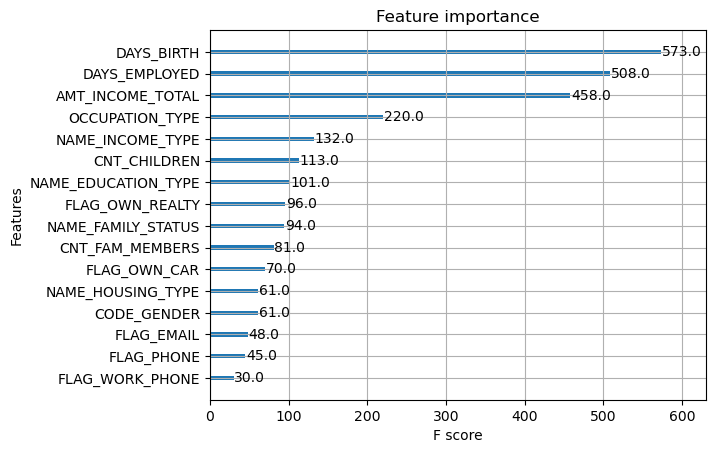

In [10]:
# Change the label to numerical for XGBoost

y_train_xgb = y_train.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 3, 'Near-prime':2})
y_test_xgb = y_test.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 3, 'Near-prime':2})


# Run XGBoost
def run_xgboost(X_train, X_test, y_train, y_test):
    xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=4, max_depth=4, 
                                       learning_rate=0.1, n_estimators=100, random_state=2)
    '''
    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(set(y_train)), 
        max_depth=4,
        learning_rate=0.1,
        n_estimators=100,
        random_state=2
    )
    '''
    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)
    
   
    xgb.plot_importance(xgb_classifier)
    plt.show()
    
    return accuracy, report

xgb_accuracy, xrb_report = run_xgboost(X_train, X_test, y_train_xgb, y_test_xgb)

k-mean clustering

In [11]:
def run_kmean(X_train, n_clusters):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    
    # Add cluster labels to the dataset
    X_train_with_clusters = X_train.copy()
    X_train_with_clusters['cluster'] = cluster_labels
    return X_train_with_clusters, kmeans


In [12]:
def run_each_cluster(X_train_with_clusters, X_test, y_train, y_test, kmeans):
    
    rf_reports = {}
    xgb_reports = {}
    rf_overall_accuracy = 0
    xgb_overall_accuracy = 0
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)  
    test_clusters = kmeans.predict(X_test_scaled) 
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['cluster'] = test_clusters

    for cluster in sorted(X_train_with_clusters['cluster'].unique()):
        print(f"\nCluster {cluster}:")

        X_train_cluster = X_train_with_clusters[X_train_with_clusters['cluster'] == cluster].drop('cluster', axis=1)
        y_train_cluster = y_train.loc[X_train_with_clusters['cluster'] == cluster]

        X_test_cluster = X_test_with_clusters[X_test_with_clusters['cluster'] == cluster].drop('cluster', axis=1)
        y_test_cluster = y_test.loc[X_test_with_clusters['cluster'] == cluster]

        '''
        # run feature selection
        print("run feature selection:")
        selector = SelectKBest(score_func=f_classif, k=n_features)
        selector.fit(X_train_cluster, y_train_cluster)

        X_train_selected = selector.transform(X_train_cluster)
        X_test_selected = selector.transform(X_test_cluster)
        selected_features = X_train_cluster.columns[selector.get_support()]
        print(f"Selected Features for Cluster {cluster}: {selected_features.tolist()}")
        '''

        # run RF:
        print("\nRun Random Forest:")
        rf_accuracy, rf_report = run_random_forest(X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster)
        rf_reports[cluster] = rf_report
        rf_overall_accuracy += rf_accuracy * X_test_cluster.shape[0]

        # run XGBoost:
        y_train_cluster_xgb = y_train_cluster.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 3, 'Near-prime': 2})
        y_test_cluster_xgb = y_test_cluster.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 3, 'Near-prime': 2})
        print("\nRun XGBoost:")
        xgb_accuracy, xgb_report = run_xgboost(X_train_cluster, X_test_cluster, y_train_cluster_xgb, y_test_cluster_xgb)
        xgb_reports[cluster] = xgb_report
        xgb_overall_accuracy += xgb_accuracy * X_test_cluster.shape[0]

    # print overall accuracy
    print("Overall Random Forest Accuracy:", rf_overall_accuracy/X_test_with_clusters.shape[0])
    print("Overall XGBoost Accuracy:", xgb_overall_accuracy/X_test_with_clusters.shape[0])

    return rf_reports, xgb_reports



Cluster 0:

Run Random Forest:
Accuracy: 0.8523908523908524
Classification Report:
              precision    recall  f1-score   support

       Prime       0.86      0.98      0.92       402
    Subprime       0.67      0.20      0.31        79

    accuracy                           0.85       481
   macro avg       0.76      0.59      0.61       481
weighted avg       0.83      0.85      0.82       481


Run XGBoost:
Accuracy: 0.8503118503118503
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       402
           1       1.00      0.09      0.16        79

    accuracy                           0.85       481
   macro avg       0.92      0.54      0.54       481
weighted avg       0.87      0.85      0.79       481



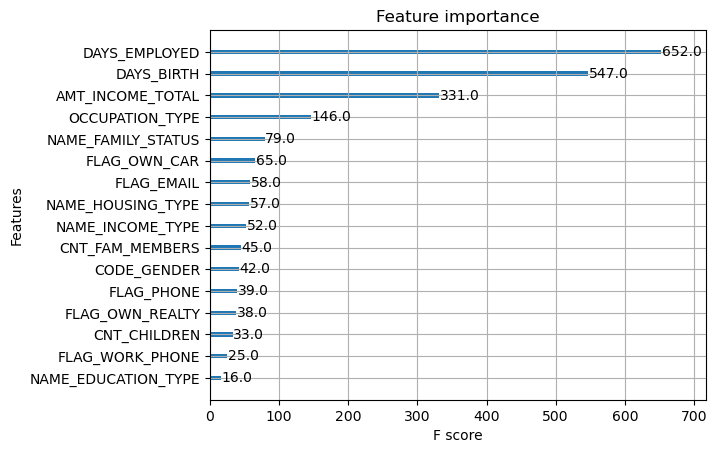


Cluster 1:

Run Random Forest:
Accuracy: 0.8827772768259693
Classification Report:
              precision    recall  f1-score   support

       Prime       0.91      0.96      0.94      4873
    Subprime       0.53      0.32      0.40       672

    accuracy                           0.88      5545
   macro avg       0.72      0.64      0.67      5545
weighted avg       0.86      0.88      0.87      5545


Run XGBoost:
Accuracy: 0.8791704238052299
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4873
           1       0.62      0.01      0.01       672

    accuracy                           0.88      5545
   macro avg       0.75      0.50      0.48      5545
weighted avg       0.85      0.88      0.82      5545



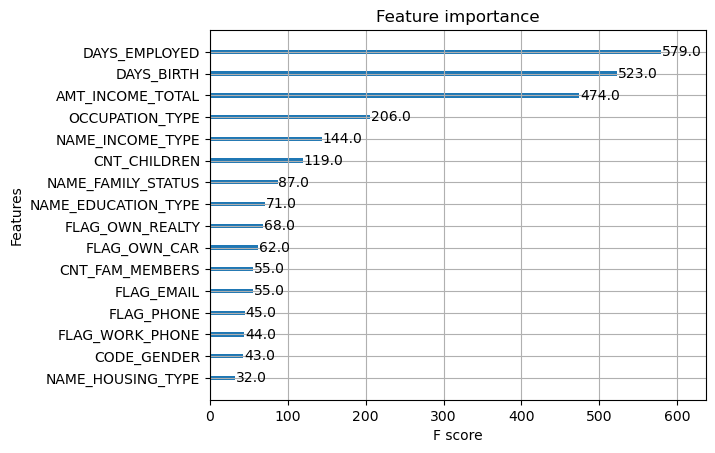


Cluster 2:

Run Random Forest:
Accuracy: 0.9052132701421801
Classification Report:
              precision    recall  f1-score   support

       Prime       0.93      0.96      0.95      1150
    Subprime       0.48      0.34      0.39       116

    accuracy                           0.91      1266
   macro avg       0.71      0.65      0.67      1266
weighted avg       0.89      0.91      0.90      1266


Run XGBoost:
Accuracy: 0.909952606635071
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1150
           1       1.00      0.02      0.03       116

    accuracy                           0.91      1266
   macro avg       0.95      0.51      0.49      1266
weighted avg       0.92      0.91      0.87      1266



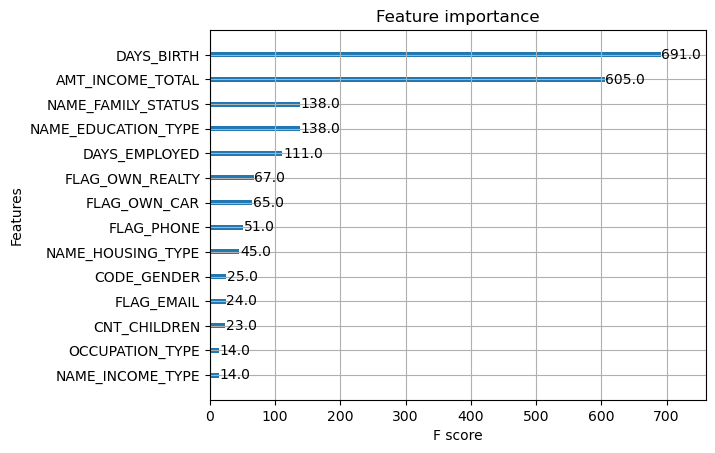

Overall Random Forest Accuracy: 0.8846681294569391
Overall XGBoost Accuracy: 0.8826110806363138


In [13]:
# run k-mean
X_train_with_clusters, kmeans = run_kmean(X_train.copy(), n_clusters=3)
rf_reports, xgb_reports = run_each_cluster(X_train_with_clusters, X_test.copy(), y_train, y_test, kmeans)